In [3]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

In [4]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [5]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
maxSeqLen = 250

In [7]:
data_train = pd.read_csv('cleaned_body.csv')

In [8]:
data_train['Body'] = data_train['Body'].apply(str)

In [9]:
# fit the tokenizer on training utterances
tokenizer_utr = Tokenizer(filters=[], lower=True, split=' ', char_level=False, oov_token='<unknown>')
tokenizer_utr.fit_on_texts(data_train['Body'])
X_train = tokenizer_utr.texts_to_sequences(data_train['Body'])
X_train = sequence.pad_sequences(X_train,maxlen=maxSeqLen,padding='post')

In [10]:
y_train = list(data_train['binary_label'])

In [11]:
# import os
# embeddings_index = {}
# f = open(os.path.join('../glove.6B.100d.txt'), encoding="utf8")
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))

In [20]:
word_index = tokenizer_utr.word_index
EMBEDDING_DIM = 100
# embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector

In [13]:
# np.save('embedding_matrix_full_6B', embedding_matrix)

In [16]:
%%time

embedding_matrix = np.load('embedding_matrix_full_6B.npy')

Wall time: 477 ms


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GRU, LSTM, Bidirectional

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxSeqLen,
                            trainable=True))
# model.add(LSTM(256))
model.add(LSTM(256))
model.add(Dense(1, activation='sigmoid'))
# model.add(Activation('softmax'))
model.compile('adam', 'binary_crossentropy')

In [23]:
y_train = np.reshape(y_train, (len(y_train),1))

In [24]:
y_train.shape

(1264216, 1)

In [37]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16887497583545428772
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6676091371
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16566203707439538729
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [25]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')

history = model.fit(X_train,y_train,verbose=1,batch_size=64,epochs=50, validation_split=0.2, callbacks=[monitor])

Train on 1011372 samples, validate on 252844 samples
Epoch 1/50
   3712/1011372 [..............................] - ETA: 5:10:47 - loss: 0.6938

KeyboardInterrupt: 

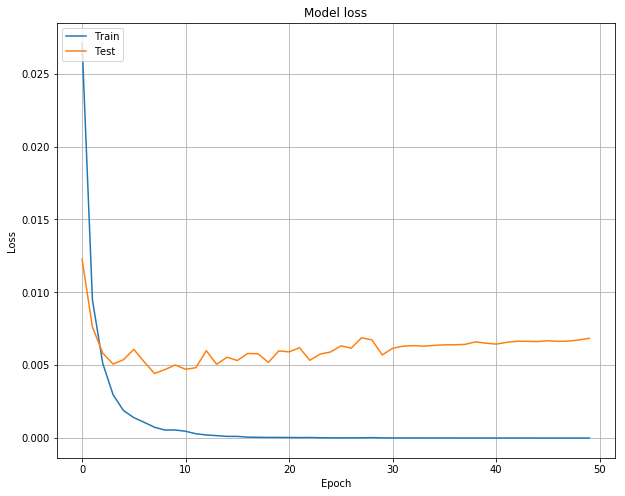

In [50]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.show()

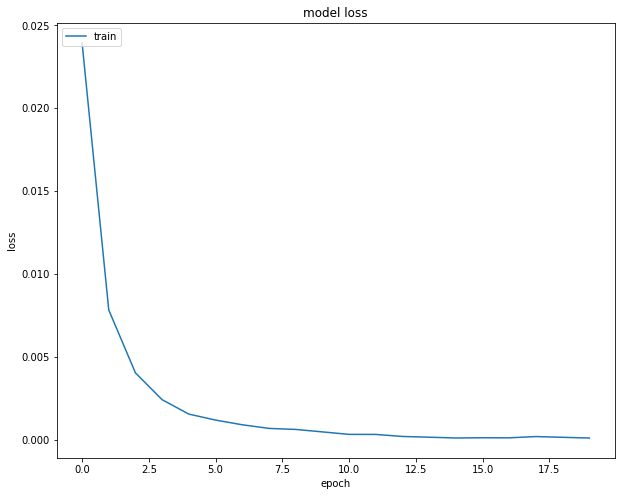

In [13]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
X_val = pd.read_fwf('dataset/hw2_utterance_dev.txt',header=None)

In [16]:
y_val = pd.read_fwf('dataset/hw2_tags_dev.txt',header=None)
y_val = y_val.iloc[:,0:1][0]
# correcting an incorrect target value
y_val[45] = y_val[45] + 6 * ' I_release_year'

In [17]:
y_val = y_val.apply(lambda x: x.split(' '))
y_val = y_val.tolist()

In [18]:
X_val = X_val.iloc[:,0:1][0]

In [19]:
X_val[45] = 'lionsgate = i would like to get a list of your movies from two thousand and nine to two thousand and twelve'

In [20]:
X_val_word = X_val = X_val.apply(bos_eos)

In [21]:
X_val = tokenizer_utr.texts_to_sequences(X_val)

In [24]:
X_val = sequence.pad_sequences(X_val,maxlen=25,padding='post')

In [25]:
labels_pred_val = []
pred = model.predict(X_val)

In [26]:
for i in pred:
    temp = []
    for j in i:
        if j.argmax() not in [0,3,4]:
            temp.append(j.argmax())
    labels_pred_val.append(temp)

In [27]:
labels_pred_val = [ list(map(lambda x: tokenizer_label.index_word[x], y)) for y in labels_pred_val]

In [29]:
from seqeval.metrics import classification_report, f1_score

In [31]:
with open("prediction.txt", 'w') as output:
    for row in labels_pred_val:
        for word in row:
            output.write(str(word) + ' ')
        output.write('\n')

In [32]:
f1_score(y_val,labels_pred_val)

0.807017543859649

In [55]:
X_val = pd.read_fwf('dataset/hw2_utterance_test.txt',header=None)

In [56]:
y_val = pd.read_fwf('dataset/hw2_utterance_test.txt',header=None)
y_val = y_val.iloc[:,0:1][0]

In [57]:
y_val = y_val.apply(lambda x: x.split(' '))
y_val = y_val.tolist()
X_val = X_val.iloc[:,0:1][0]

In [58]:
X_val_word = X_val = X_val.apply(bos_eos)

In [59]:
X_val = tokenizer_utr.texts_to_sequences(X_val)

In [60]:
X_val = sequence.pad_sequences(X_val,maxlen=25,padding='post')

In [61]:
labels_pred_val = []
pred = model.predict(X_val)

In [63]:
for i in pred:
    temp = []
    for j in i:
        if j.argmax() not in [0,3,4]:
            temp.append(j.argmax())
    labels_pred_val.append(temp)

In [64]:
labels_pred_val = [ list(map(lambda x: tokenizer_label.index_word[x], y)) for y in labels_pred_val]

In [65]:
with open("prediction.txt", 'w') as output:
    for row in labels_pred_val:
        for word in row:
            output.write(str(word) + ' ')
        output.write('\n')